In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
from pylab import mpl, plt
import seaborn as sns
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [ ]:
data = yf.download('XOM', 
                    start='2022-6-01', 
                    end='2022-10-30')


[*********************100%***********************]  1 of 1 completed


In [ ]:
# Calculate the average spread of daily high and low prices of the stock
# during the specified time period (in this case, from start date to 
# end date, 2022 for the Exxon Mobil Corporation stock).
spread = (data['High'] - data['Low']).mean()

# Print the calculated average spread
spread


2.6518089657738093

In [ ]:
# Calculate the mid-closing price of the stock for each trading day
data['Midclose'] = (data['High'] + data['Low']) / 2

# Print the first few rows of the DataFrame to show the new 'Midclose' column
data.head()


,Open,High,Low,Close,Adj Close,Volume,Midclose
Date,,,,,,,
2022-06-01,97.019997,98.709999,96.620003,97.839996,95.390656,25815400,97.665001
2022-06-02,97.290001,98.099998,96.790001,97.669998,95.224915,19089100,97.445000
2022-06-03,97.900002,99.660004,97.900002,99.089996,96.609367,21038200,98.780003
2022-06-06,99.180000,99.779999,98.669998,98.839996,96.365623,20682100,99.224998
2022-06-07,99.699997,103.430000,99.489998,103.370003,100.782227,37810200,101.459999


In [ ]:
# The code assumes that trades will be executed at the mid-closing price of the stock. 
# This assumption may not hold in practice, as actual trades may occur at prices above or 
# below the mid-closing price, which could affect the accuracy of the results.

In [ ]:
# The average proportional transaction costs given the average spread
# and the average mid close price.
ptc = spread / data['Midclose'].mean()  
ptc 

0.02826276350226296

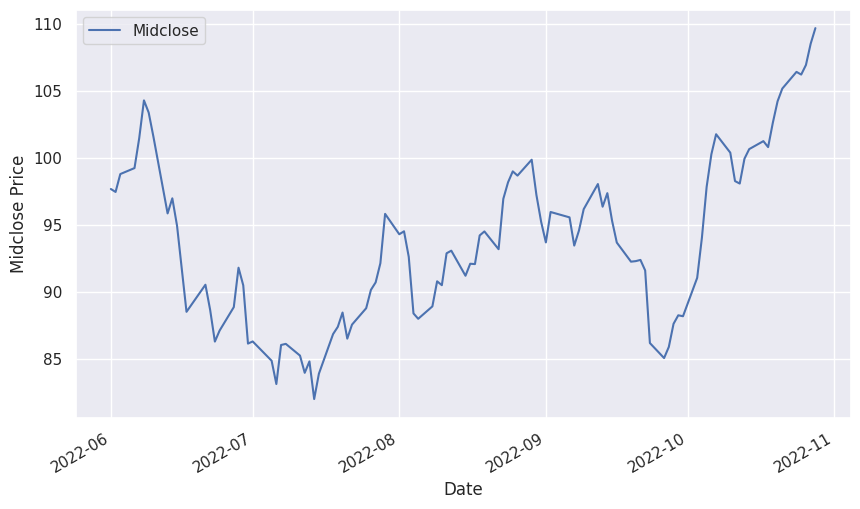

In [ ]:
# Set seaborn style
sns.set(style='darkgrid')

# Plot Midclose data
data['Midclose'].plot(figsize=(10, 6), legend=True)

# Add axis labels
plt.xlabel('Date')
plt.ylabel('Midclose Price')

# Display the plot
plt.show()

In [ ]:
data['Returns'] = np.log(data['Midclose'] / data['Midclose'].shift(1))  # log returns
data.dropna(inplace=True)  # drop rows with missing values

lags = 5

In [ ]:
# Create an empty list to store column names for lagged returns
cols = []

# For each lag up to and including 'lags'
for lag in range(1, lags + 1):
    
    # Create a column name using the current lag
    col = 'lag_{}'.format(lag)
    
    # Shift the returns by the current lag and assign it to a new column with the current column name
    data[col] = data['Returns'].shift(lag)  
    
    # Append the current column name to the list of column names for lagged returns
    cols.append(col)

# Convert the lagged returns to a binary matrix where 1 indicates a positive return and 0 indicates a negative return
data[cols] = np.where(data[cols] > 0, 1, 0)  

# Create a column called 'Direction' where 1 indicates a positive return and -1 indicates a negative return
data['Direction'] = np.where(data['Returns'] > 0, 1, -1)  

# Display the first few rows of the dataframe including the lagged returns and the direction of each return
data[cols + ['Direction']].head()


,lag_1,lag_2,lag_3,lag_4,lag_5,Direction
Date,,,,,,
2022-06-02,0,0,0,0,0,-1
2022-06-03,0,0,0,0,0,1
2022-06-06,1,0,0,0,0,1
2022-06-07,1,1,0,0,0,1
2022-06-08,1,1,1,0,0,1


In [ ]:
# Create a support vector machine model with a linear kernel
model = SVC(C=1, kernel='linear')

# Test/train split
split = int(len(data) * 0.80)
train = data.iloc[:split].copy()
test = data.iloc[split:].copy()

# Fit the model on the training data
model.fit(train[cols], train['Direction'])

# Make predictions on the test data
test['Predicted_Direction'] = model.predict(test[cols])

In [ ]:
# Print the classification report and confusion matrix
print(classification_report(test['Direction'], test['Predicted_Direction']))
print(confusion_matrix(test['Direction'], test['Predicted_Direction']))

              precision    recall  f1-score   support

          -1       0.00      0.00      0.00         6
           1       0.71      1.00      0.83        15

    accuracy                           0.71        21
   macro avg       0.36      0.50      0.42        21
weighted avg       0.51      0.71      0.60        21

[[ 0  6]
 [ 0 15]]


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# Predictions
test = data.iloc[split:].copy()
test['Predicted'] = model.predict(test[cols])

# Accuracy
accuracy = accuracy_score(test['Direction'], test['Predicted'])
print('Accuracy:', accuracy)

Accuracy: 0.7142857142857143


In [ ]:
# In this context, the confusion matrix is a table used to evaluate the 
# performance of a classification model. It compares the predicted class labels with the actual 
# class labels in the test data to calculate the number of true positives, true negatives, false 
# positives, and false negatives. From the confusion matrix, we can calculate metrics such as 
# accuracy, precision, recall, and F1-score.

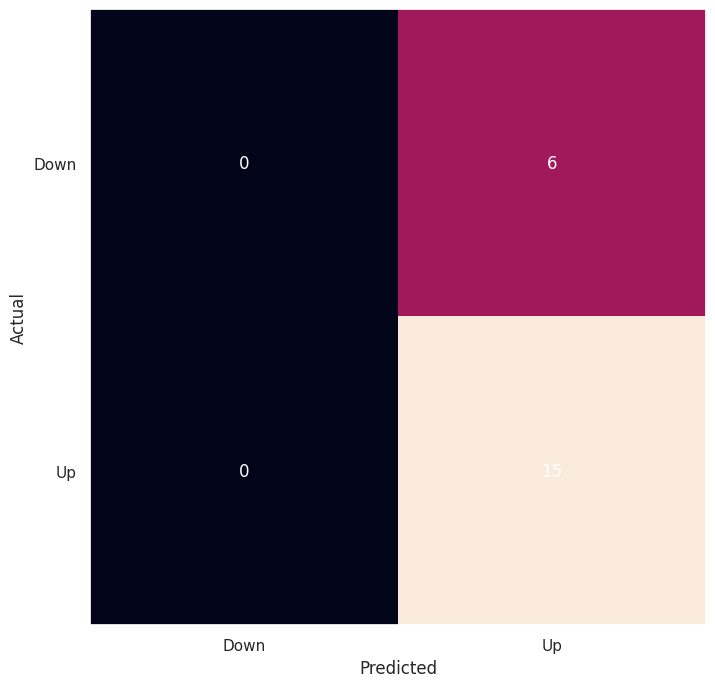

In [ ]:
# Confusion Matrix
cm = confusion_matrix(test['Direction'], test['Predicted'])
fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(cm)
ax.grid(False)
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
ax.xaxis.set(ticks=(0, 1), ticklabels=('Down', 'Up'))
ax.yaxis.set(ticks=(0, 1), ticklabels=('Down', 'Up'))
for i in range(2):
    for j in range(2):
        ax.text(j, i, cm[i, j], ha='center', va='center', color='white')
plt.show()

In [ ]:
# Confusion Matrix
cm = confusion_matrix(test['Direction'], test['Predicted'])
print("Confusion Matrix:\n", cm)


Confusion Matrix:
 [[ 0  6]
 [ 0 15]]


In [ ]:
#GRID SEARCH FIX THIS

In [ ]:
# Define the grid of hyperparameters to search over
param_grid = {'C': [0.1, 1, 10, 100], 'kernel': ['linear', 'poly', 'rbf', 'sigmoid'], 'degree': [2, 3, 4, 5]}

# Create a new SVM model
model = SVC()

# Use GridSearchCV to find the best hyperparameters
grid = GridSearchCV(model, param_grid, cv=5, scoring='accuracy')
grid.fit(train[cols], train['Direction'])

GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'C': [0.1, 1, 10, 100], 'degree': [2, 3, 4, 5],
                         'kernel': ['linear', 'poly', 'rbf', 'sigmoid']},
             scoring='accuracy')

In [ ]:
# Print the best hyperparameters
print("Best hyperparameters:", grid.best_params_)


Best hyperparameters: {'C': 0.1, 'degree': 2, 'kernel': 'linear'}


In [ ]:
# Train the model with the best hyperparameters
best_model = grid.best_estimator_
best_model.fit(train[cols], train['Direction'])

# Make predictions on the test set
test = data.iloc[split:].copy()
test['Predicted'] = best_model.predict(test[cols])


In [ ]:
# Compute the accuracy and confusion matrix
accuracy = accuracy_score(test['Direction'], test['Predicted'])
print("Accuracy:", accuracy)
print("Confusion Matrix:\n", confusion_matrix(test['Direction'], test['Predicted']))


Accuracy: 0.7142857142857143
Confusion Matrix:
 [[ 0  6]
 [ 0 15]]


In [ ]:
# Create a new column 'Position' based on the predicted direction
test['Position'] = np.where(test['Predicted'] == 1, 1, -1)

# Calculate the strategy returns by multiplying position with log returns
test['Strategy'] = test['Position'] * test['Returns']

# Calculate cumulative strategy returns
test['Cumulative_Strategy_Returns'] = test['Strategy'].cumsum()

# Calculate cumulative buy and hold returns
test['Cumulative_Buy_and_Hold_Returns'] = (test['Returns'] + 1).cumprod() - 1


In [ ]:
# Calculate strategy and buy and hold annualized returns
strategy_cumulative_return = np.exp(test['Strategy'].cumsum())[-1] # cumulative return over the period
strategy_annualized_return = strategy_cumulative_return ** (252 / len(test)) - 1 # raise to the power of 252 / n, where n is the number of years in the period

buy_and_hold_cumulative_return = np.exp(test['Returns'].cumsum())[-1] # cumulative return over the period
buy_and_hold_annualized_return = buy_and_hold_cumulative_return ** (252 / len(test)) - 1 # raise to the power of 252 / n, where n is the number of years in the period


In [ ]:
strategy_annualized_volatility = test['Strategy'].std() * np.sqrt(252)
buy_and_hold_annualized_volatility = test['Returns'].std() * np.sqrt(252)


# Calculate strategy and buy and hold Sharpe ratios
strategy_sharpe_ratio = strategy_annualized_return / strategy_annualized_volatility
buy_and_hold_sharpe_ratio = buy_and_hold_annualized_return / buy_and_hold_annualized_volatility

In [ ]:
# Print strategy and buy and hold performance metrics
print('Strategy Annualized Return:', strategy_annualized_return)
print('Strategy Annualized Volatility:', strategy_annualized_volatility)
print('Strategy Sharpe Ratio:', strategy_sharpe_ratio)
print('Buy and Hold Annualized Return:', buy_and_hold_annualized_return)
print('Buy and Hold Annualized Volatility:', buy_and_hold_annualized_volatility)
print('Buy and Hold Sharpe Ratio:', buy_and_hold_sharpe_ratio)

Strategy Annualized Return: 12.568609156161022
Strategy Annualized Volatility: 0.23714046939434857
Strategy Sharpe Ratio: 53.000692746628054
Buy and Hold Annualized Return: 12.568609156161022
Buy and Hold Annualized Volatility: 0.23714046939434857
Buy and Hold Sharpe Ratio: 53.000692746628054


In [ ]:
# Calculate transaction costs for each trade
test['Transaction_Costs'] = np.where(test['Position'].diff() != 0,
                                     abs(test['Position'].diff()) * ptc,
                                     0)
# Apply transaction costs to strategy returns
test['Strategy_with_TC'] = test['Strategy'] - test['Transaction_Costs']


In [ ]:
# Calculate daily returns
daily_returns = test['Strategy_with_TC']

# Calculate VaR at 95% confidence level
var_95 = daily_returns.quantile(0.05)

# Calculate CVaR at 95% confidence level
cvar_95 = daily_returns[daily_returns <= var_95].mean()


In [ ]:
# Calculate daily returns, strategy, and strategy with transaction costs
test['Returns_daily'] = test['Midclose'].pct_change()
test['Strategy_daily'] = test['Position'] * test['Returns_daily']
test['Strategy_with_TC_daily'] = test['Strategy_with_TC'] * test['Position']

# Calculate annualized returns, strategy, and strategy with transaction costs
returns_annualized = test['Returns_daily'].mean() * 252
strategy_annualized = test['Strategy_daily'].mean() * 252
strategy_with_TC_annualized = test['Strategy_with_TC_daily'].mean() * 252

# Print the results
print("Daily returns: {:.2%}".format(test['Returns_daily'].mean()))
print("Strategy daily return: {:.2%}".format(test['Strategy_daily'].mean()))
print("Strategy with TC daily return: {:.2%}".format(test['Strategy_with_TC_daily'].mean()))
print("Annualized returns: {:.2%}".format(returns_annualized))
print("Annualized strategy return: {:.2%}".format(strategy_annualized))
print("Annualized strategy with TC return: {:.2%}".format(strategy_with_TC_annualized))


Daily returns: 1.11%
Strategy daily return: 1.11%
Strategy with TC daily return: 1.09%
Annualized returns: 279.08%
Annualized strategy return: 279.08%
Annualized strategy with TC return: 274.81%


In [ ]:
num_trades = (test['Position'].diff() != 0).sum()
print('Number of trades:', num_trades)


Number of trades: 1


In [ ]:
# Create a subplot with two charts
fig = make_subplots(rows=2, cols=1, shared_xaxes=True)

# Add the daily returns of the strategy without transaction costs to the first chart
fig.add_trace(go.Scatter(x=test.index, y=test['Strategy_daily'].cumsum(),
                         mode='lines', name='Strategy_daily'), row=1, col=1)

# Add the daily returns of the strategy with transaction costs to the first chart
fig.add_trace(go.Scatter(x=test.index, y=test['Strategy_with_TC_daily'].cumsum(),
                         mode='lines', name='Strategy_with_TC_daily'), row=1, col=1)

# Add the daily returns of the strategy without transaction costs to the second chart
fig.add_trace(go.Scatter(x=test.index, y=test['Strategy_daily'],
                         mode='lines', name='Strategy_daily'), row=2, col=1)

# Add the daily returns of the strategy with transaction costs to the second chart
fig.add_trace(go.Scatter(x=test.index, y=test['Strategy_with_TC_daily'],
                         mode='lines', name='Strategy_with_TC_daily'), row=2, col=1)

# Update the chart layout
fig.update_layout(title='Daily Returns of the Trading Strategies',
                  xaxis_title='Date', yaxis_title='Returns')

# Show the chart
fig.show()


In [ ]:
# Create a subplot with two charts
fig = make_subplots(rows=2, cols=1, shared_xaxes=True)

# Add the cumulative daily returns of the strategy without transaction costs to the first chart
fig.add_trace(go.Scatter(x=test.index, y=test['Strategy_daily'].cumsum(),
                         mode='lines', name='Cumulative Strategy without TC'), row=1, col=1)

# Add the cumulative daily returns of the strategy with transaction costs to the first chart
fig.add_trace(go.Scatter(x=test.index, y=test['Strategy_with_TC_daily'].cumsum(),
                         mode='lines', name='Cumulative Strategy with TC'), row=1, col=1)

# Add the daily returns of the strategy without transaction costs to the second chart
fig.add_trace(go.Scatter(x=test.index, y=test['Strategy_daily'],
                         mode='lines', name='Daily Strategy without TC'), row=2, col=1)

# Add the daily returns of the strategy with transaction costs to the second chart
fig.add_trace(go.Scatter(x=test.index, y=test['Strategy_with_TC_daily'],
                         mode='lines', name='Daily Strategy with TC'), row=2, col=1)

# Update the chart layout
fig.update_layout(title='Daily Returns of the Trading Strategies',
                  xaxis_title='Date', yaxis_title='Returns')

# Show the chart
fig.show()


In [ ]:
print('VaR at 95% confidence level:', round(var_95, 4))
print('CVaR at 95% confidence level:', round(cvar_95, 4))


VaR at 95% confidence level: -0.014
CVaR at 95% confidence level: -0.0213
